In [9]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.03.3 installation finished!


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from sklearn.preprocessing import OneHotEncoder


df=pd.read_csv("molecules.csv")
df=df.dropna(how="all")
df=df.iloc[:,:3]
df["Nomenclature Name"]=df.iloc[:,2]
df["Molecular Structure"]=df.iloc[:,1]
df["Tg"]=df.iloc[:,0]
df=df[["Nomenclature Name","Molecular Structure","Tg"]]
df.head(10)

,Nomenclature Name,Molecular Structure,Tg
0,Poly(4-biphenyl acrylate),C=CC(=O)Oc2ccc(c1ccccc1)cc2,383.0
1,Poly(butyl acrylate),CCCCOC(=O)C=C,219.0
2,Poly(sec-butyl acrylate),CC(OC(=O)C=C)CC,250.0
3,Poly(2-tertbutylphenyl acrylate),C=CC(=O)Oc1ccccc1C(C)(C)C,345.0
4,Poly(4-tertbutylphenyl acrylate),C=CC(=O)Oc1ccc(C(C)(C)C)cc1,344.0
7,Poly(4-cyanobenzyl acrylate),C=CC(=O)Oc1ccc(C#N)cc1,317.0
8,Poly(2-cyanoisobutyl acrylate),C=CC(=O)OCC(C)C#N,324.0
9,Poly(2-cyanoethyl acrylate),C=CC(=O)OCCC#N,277.0
10,Poly(2-cyanohexyl acrylate),C=CC(=O)OCCCCCCC#N,358.0
11,Poly(2-cyanoisopropyl acrylate),C=CC(=O)OC(C)C#N,339.0


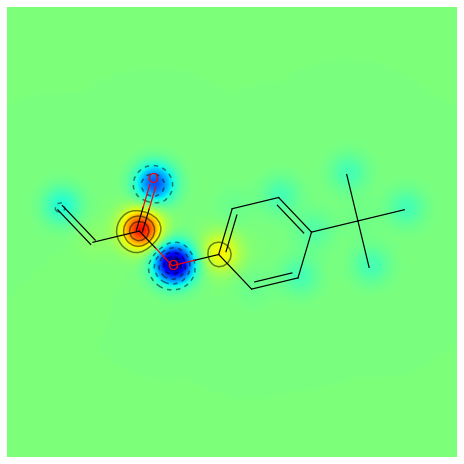

In [11]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('C=CC(=O)Oc1ccc(C(C)(C)C)cc1	')
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
AllChem.ComputeGasteigerCharges(mol)



In [12]:
def encoding(df):
  encoded=[]
  elements=[['c'], ['n'], ['o'], ['C'], ['N'], ['F'], ['='], ['O'], 
            ['('], [')'], ['1'],['2'],['#'],['Cl'],['/']]
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(elements)
  enc.categories_
  df1=df["Molecular Structure"].apply(lambda x: pd.Series(list(x)))
  for i in range(df1.shape[0]):
    x=enc.transform(pd.DataFrame(df1.iloc[i,:]).dropna(how="all").values).toarray()
    y=np.zeros(((df1.shape[1]-x.shape[0]),len(elements)))
    encoded.append(np.vstack((x,y)))
  return encoded

def encoded_generate_images(df):
  listt=encoding(df)
  plt.figure(figsize=(20,100))
  for i in range(len(listt)):
    plt.subplot(len(listt),5,i+1)
    plt.imshow(listt[i])

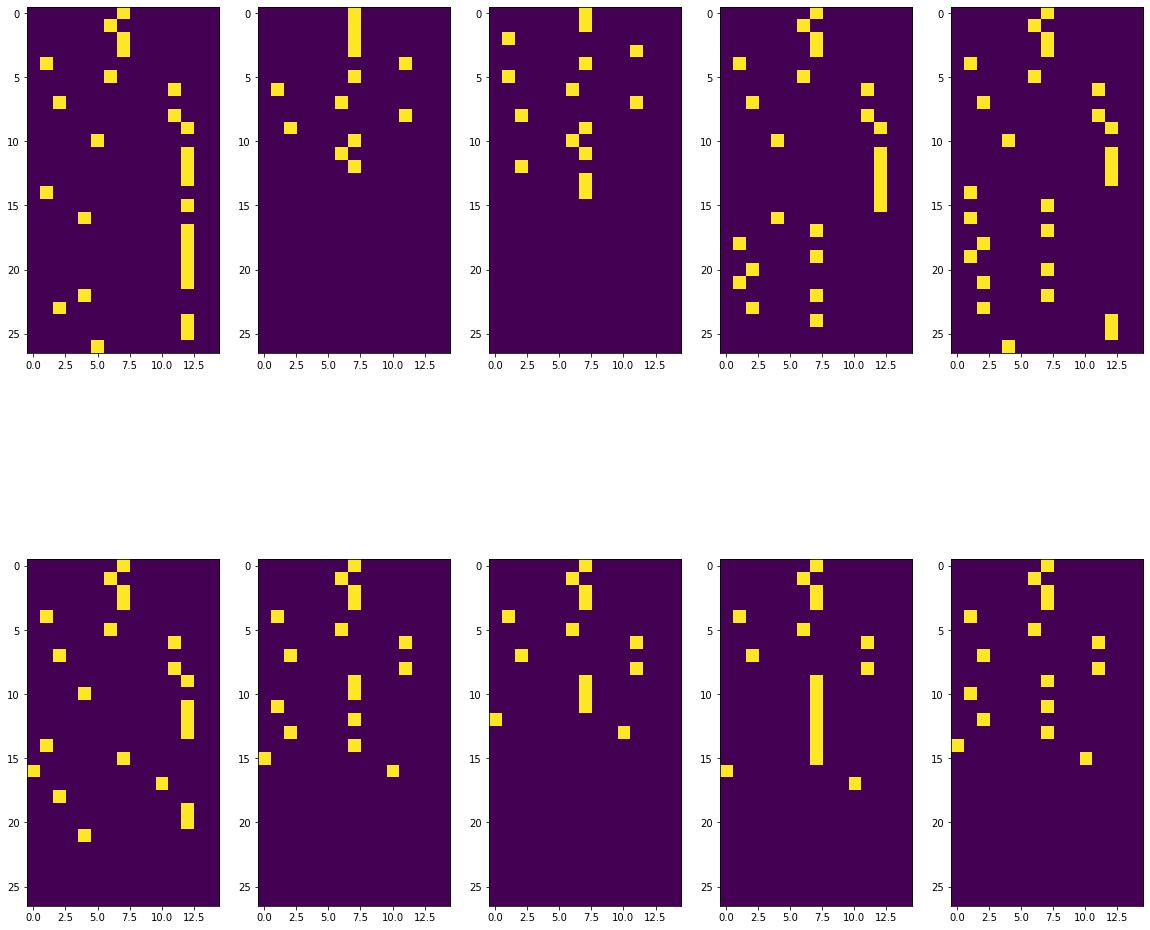

In [13]:
encoded_generate_images(df.head(10))

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense,MaxPool2D,Conv2D,Conv1D,Flatten,MaxPooling1D
from keras import optimizers
from keras.layers import Dropout

Using TensorFlow backend.


In [15]:
X=encoding(df)
X=np.array(X)
X.shape

(102, 58, 15)

In [16]:
Y=df["Tg"].values
Y.shape

(102,)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=8, activation='relu',kernel_regularizer="l2", input_shape=(58, 15)))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
optimizer=optimizers.adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=50,batch_size=16,validation_split=0.2)
  


Train on 72 samples, validate on 19 samples
Epoch 1/50
72/72 [==============================] - 0s 2ms/step - loss: 298.8824 - val_loss: 282.5479
Epoch 2/50
72/72 [==============================] - 0s 393us/step - loss: 280.6631 - val_loss: 252.0884
Epoch 3/50
72/72 [==============================] - 0s 384us/step - loss: 229.3876 - val_loss: 182.6381
Epoch 4/50
72/72 [==============================] - 0s 426us/step - loss: 137.1246 - val_loss: 57.1797
Epoch 5/50
72/72 [==============================] - 0s 420us/step - loss: 84.4007 - val_loss: 48.2213
Epoch 6/50
72/72 [==============================] - 0s 380us/step - loss: 90.2793 - val_loss: 31.8627
Epoch 7/50
72/72 [==============================] - 0s 433us/step - loss: 63.0435 - val_loss: 58.1715
Epoch 8/50
72/72 [==============================] - 0s 377us/step - loss: 56.6739 - val_loss: 31.7239
Epoch 9/50
72/72 [==============================] - 0s 361us/step - loss: 44.4436 - val_loss: 26.7387
Epoch 10/50
72/72 [==============

In [44]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 51, 128)           15488     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                64050     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 79,589
Trainable params: 79,589
Non-trainable params: 0
__________________________________________________

In [48]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
MAE_test=abs(y_predtest.reshape(y_test.shape)-y_test).sum()/y_test.shape
MAE_train=abs(y_predtrain.reshape(y_train.shape)-y_train).sum()/y_train.shape
print("Mean Absolute Error on Training Set = ",MAE_train.item())
print("Mean Absolute Error on Test Set = ",MAE_test.item())

Mean Absolute Error on Training Set =  12.154252440064818
Mean Absolute Error on Test Set =  19.833858143199574


(21,)

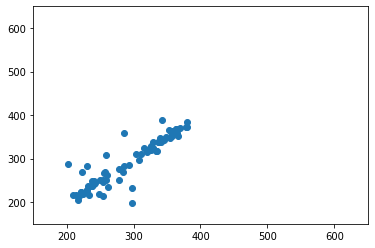

In [40]:
import matplotlib.pyplot as plt
plt.scatter(y_predtrain,y_train.reshape(81,1))
plt.xlim([150,650])
plt.ylim([150,650])
y_train.shape
y_test.shape


In [41]:
y_predtrain.reshape(81)
y_train.reshape(81)
import plotly.express as px
fig = px.scatter(x=y_predtrain.reshape(81), y=y_train.reshape(81))
fig.show()



In [32]:
import plotly.graph_objects as go
import numpy as np




fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_predtrain.reshape(81), y=y_train.reshape(81),
    name='sin',
    mode='markers',
    marker_color='rgba(100, 1, 0, .8)'))

fig.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig.update_layout(title='Styled Scatter',
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()


In [33]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtrain.reshape(81),
    y = y_train.reshape(81),
    mode='markers',
    marker=dict(
        color=np.random.randn(81),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()

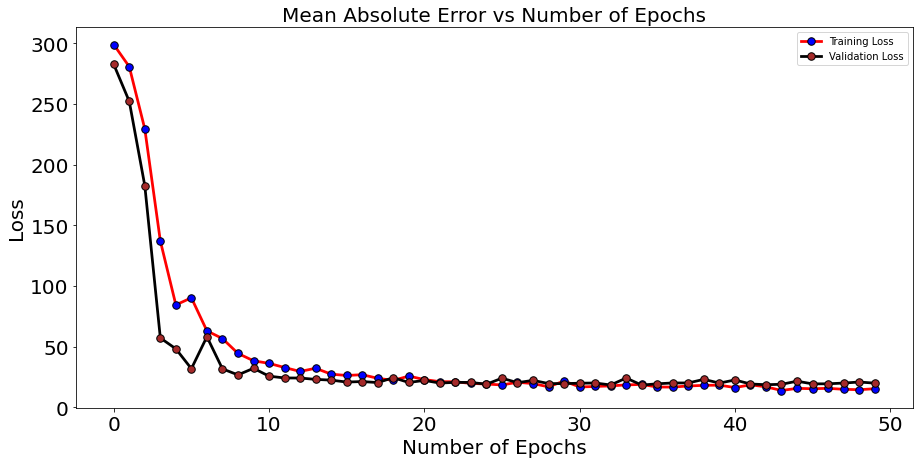

In [45]:
plt.figure(figsize=(15,7))
plt.plot(Model.history["loss"],color='r', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='b',
         markeredgecolor='black',
         markeredgewidth=1,label="Training Loss")
plt.plot(Model.history['val_loss'],color='black', linewidth=2.75, linestyle='-', marker='.', markersize=15,markerfacecolor='brown',
         markeredgecolor='black',
         markeredgewidth=1,label="Validation Loss")
plt.xlabel("Number of Epochs",size=20,color="black")
plt.ylabel("Loss",size=20,color="black")
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Mean Absolute Error vs Number of Epochs",size=20)
plt.legend()
plt.show()

### Neural Network using Bond Features

In [155]:
mw={"C":12,"c":12,"O":16,"o":16,"N":14,"F":19}
def Molecular_Weight(text):
  Mass=[]
  for elements in text:
    if elements=="C":
      Mass.append(mw[elements])
    elif elements=="c":
      Mass.append(mw[elements])
    elif elements=="o":
      Mass.append(mw[elements])
    elif elements=="O":
      Mass.append(mw[elements])
    elif elements=="F":
      Mass.append(mw[elements])
    elif elements=="N":
      Mass.append(mw[elements])  
  return sum(Mass)

In [1]:
df["C_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c'))
df["C_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('C'))
df["O_Atoms_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('O'))
df["O_Atoms_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('o'))
df["N_Double Bonds_Ring"]=df["Molecular Structure"].apply(lambda x: x.count('c')/2)
df["N_Double Bonds_Chain"]=df["Molecular Structure"].apply(lambda x: x.count('='))
df["Nitrogen_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('N'))
df["F_Atoms"]=df["Molecular Structure"].apply(lambda x: x.count('F'))
df["MW"]=df["Molecular Structure"].apply(lambda x: Molecular_Weight(x))
df["Total Number of Atoms"]=df["Molecular Structure"].apply(lambda x: len(x))
df["Number of Single Bonds"]=df["Molecular Structure"].apply(lambda x:len(x)-x.count('=')-1)

NameError: name 'df' is not defined

In [231]:
df.head()

,Nomenclature Name,Molecular Structure,Tg,Number of Carbon Atoms in Ring,MW,C_Atoms_Ring,C_Atoms_Chain,O_Atoms_Chain,O_Atoms_Ring,N_Double Bonds_Ring,N_Double Bonds_Chain,Nitrogen_Atoms,F_Atoms,Total Number of Atoms,Number of Single Bonds
0,Poly(4-biphenyl acrylate),C=CC(=O)Oc2ccc(c1ccccc1)cc2,383.0,12,212,12,3,2,0,6.0,2,0,0,27,24
1,Poly(butyl acrylate),CCCCOC(=O)C=C,219.0,0,116,0,7,2,0,0.0,2,0,0,13,10
2,Poly(sec-butyl acrylate),CC(OC(=O)C=C)CC,250.0,0,116,0,7,2,0,0.0,2,0,0,15,12
3,Poly(2-tertbutylphenyl acrylate),C=CC(=O)Oc1ccccc1C(C)(C)C,345.0,6,188,6,7,2,0,3.0,2,0,0,25,22
4,Poly(4-tertbutylphenyl acrylate),C=CC(=O)Oc1ccc(C(C)(C)C)cc1,344.0,6,188,6,7,2,0,3.0,2,0,0,27,24


In [232]:
X=df.loc[:,"MW":]
Y=df[["Tg"]]

In [233]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X.shape

(102, 11)

In [245]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [251]:
model = Sequential()
model.add(Dense(40, input_dim=11, activation="relu",kernel_regularizer="l2"))
#model.add(Dense(20,activation="relu",kernel_regularizer="l2"))
model.add(Dense(10,activation="relu",kernel_regularizer="l2"))
#model.add(Dense(12, activation="relu",kernel_regularizer="l2"))
model.add(Dense(1))

In [247]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 40)                480       
_________________________________________________________________
dense_112 (Dense)            (None, 10)                410       
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 11        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [252]:
optimizer=optimizers.adam(lr=0.09)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=70,batch_size=64,validation_split=0.1)
  

Train on 72 samples, validate on 9 samples
Epoch 1/70
72/72 [==============================] - 0s 2ms/step - loss: 296.5094 - val_loss: 269.0650
Epoch 2/70
72/72 [==============================] - 0s 163us/step - loss: 286.0569 - val_loss: 232.3117
Epoch 3/70
72/72 [==============================] - 0s 112us/step - loss: 250.9392 - val_loss: 193.8465
Epoch 4/70
72/72 [==============================] - 0s 145us/step - loss: 193.3730 - val_loss: 195.9764
Epoch 5/70
72/72 [==============================] - 0s 119us/step - loss: 137.9410 - val_loss: 166.9417
Epoch 6/70
72/72 [==============================] - 0s 118us/step - loss: 125.5268 - val_loss: 126.8414
Epoch 7/70
72/72 [==============================] - 0s 132us/step - loss: 111.4854 - val_loss: 100.9139
Epoch 8/70
72/72 [==============================] - 0s 177us/step - loss: 85.6305 - val_loss: 101.5332
Epoch 9/70
72/72 [==============================] - 0s 124us/step - loss: 76.5435 - val_loss: 110.5667
Epoch 10/70
72/72 [======

In [260]:
y_predtrain=model.predict(X_train)
y_predtest=model.predict(X_test)
print("Train Error = ",abs(y_predtrain.reshape(81)-y_train.values.reshape(81)).sum()/81)
print("Unseen Test Error = ",abs(y_predtest.reshape(21)-y_test.values.reshape(21)).sum()/21)

Train Error =  17.74619980800299
Unseen Test Error =  14.115353538876487


In [254]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtrain.reshape(81),
    y = y_train.values.reshape(81),
    mode='markers',
    marker=dict(
        color=np.random.randn(21),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()

In [255]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scattergl(
    x = y_predtest.reshape(21),
    y = y_test.values.reshape(21),
    mode='markers',
    marker=dict(
        color=np.random.randn(81),
        colorscale='Viridis',
        line_width=2
    )
))

fig.show()